# Summary

# Imports

In [1]:
import concurrent.futures
import io
import itertools
import multiprocessing
import os
import os.path as op
import pickle
import subprocess
import tempfile
from functools import partial
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import seaborn as sns
import sqlalchemy as sa
from scipy import stats

from kmtools import py_tools, sequence_tools

In [2]:
%matplotlib inline

In [3]:
pd.set_option("max_columns", 100)

# Parameters

In [4]:
NOTEBOOK_PATH = Path('validation_training_stats')
NOTEBOOK_PATH

PosixPath('validation_training_stats')

In [5]:
OUTPUT_PATH = Path(os.getenv('OUTPUT_DIR', NOTEBOOK_PATH.name)).resolve()
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)
OUTPUT_PATH

PosixPath('/scratch/strokach/datapkg/adjacency-net-v2/notebooks/validation_training_stats')

In [6]:
proc = subprocess.run(["git", "rev-parse", "--short", "HEAD"], stdout=subprocess.PIPE)
GIT_REV = proc.stdout.decode().strip()
GIT_REV

'2802e3b'

In [7]:
TASK_ID = os.getenv("SLURM_ARRAY_TASK_ID")
TASK_COUNT = os.getenv("ORIGINAL_ARRAY_TASK_COUNT") or os.getenv("SLURM_ARRAY_TASK_COUNT")
NETWORK_NAME = os.getenv("NETWORK_NAME", GIT_REV)

TASK_ID = int(TASK_ID) if TASK_ID is not None else None
TASK_COUNT = int(TASK_COUNT) if TASK_COUNT is not None else None

TASK_ID, TASK_COUNT, NETWORK_NAME

(None, None, '2802e3b')

In [8]:
DEBUG = "CI" not in os.environ    
DEBUG

True

In [9]:
# if DEBUG:
#     %load_ext autoreload
#     %autoreload 2

# `DATAPKG`

In [10]:
DATAPKG = {
    'adjacency_net_v2': {
        'training_dataset':
            Path(os.environ['DATAPKG_OUTPUT_DIR'])
            .joinpath("adjacency-net-v2", "master", "training_dataset", "adjacency_matrix.parquet")
    }
}

# Load data

## Subset of rows from training dataset

### `sample_df`

In [11]:
folders = sorted(DATAPKG['adjacency_net_v2']['training_dataset'].glob("database_id=*"))

In [12]:
dfs = []
for folder in np.random.permutation(folders)[:20]:
    files = list(folder.glob("*.parquet"))
    assert len(files) == 1
    file = files[0]
    df = pq.ParquetFile(file).read_row_group(0).to_pandas()
    dfs.append(df)

In [13]:
sample_df = pd.concat(dfs, ignore_index=True)

In [14]:
display(sample_df.head(1))
print(len(sample_df))

,__index_level_0__,uniparc_id,sequence,database,interpro_name,interpro_id,domain_start,domain_end,domain_length,structure_id,model_id,chain_id,pc_identity,alignment_length,mismatches,gap_opens,q_start,q_end,s_start,s_end,evalue_log10,bitscore,qseq,sseq,a2b,b2a,residue_idx_1,residue_idx_2,residue_id_1,residue_id_2,residue_aa_1,residue_aa_2,residue_idx_1_corrected,residue_idx_2_corrected
0,842061419,UPI000050872A,RVTWMRRMRILHQLLRRYWESKTMDHHMYLSLYLKVKSNVSKNQWI...,Gene3D,"Ribosomal protein L19/L19e, domain 3",IPR015974,272,326,55,4V6W,0.0,XA,51.92,52.0,25.0,0.0,4.0,55.0,95.0,146.0,-11.0,58.2,WMRRMRILHQLLRRYWESKTMDHHMYLSLYLKVKSNVSKNQWILME...,WMQRQRVLRRLLKKYRDSKKIDRHLYHDLYMKCKGNVFKNKRVLME...,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[94.0, 94.0, 94.0, 94.0, 94.0, 94.0, 94.0, 95....","[95.0, 96.0, 97.0, 98.0, 99.0, 126.0, 129.0, 9...","[95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 96....","[96.0, 97.0, 98.0, 99.0, 100.0, 127.0, 130.0, ...","[W, W, W, W, W, W, W, M, M, M, M, M, Q, Q, Q, ...","[M, Q, R, Q, R, C, N, W, Q, R, Q, R, W, M, R, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...","[1.0, 2.0, 3.0, 4.0, 5.0, 32.0, 35.0, 0.0, 2.0..."


291761


In [15]:
assert (sample_df['qseq'].str.len() == sample_df['sseq'].str.len()).all()

In [16]:
assert sample_df['qseq'].str.contains('-').any()

In [17]:
assert sample_df['sseq'].str.contains('-').any()

### Permute sequence

In [18]:
sample_df = sample_df[sample_df['qseq'].str.len() > 12]

In [19]:
def permute_seq(seq):
    div = np.random.randint(6, len(seq) - 6)
    return seq[div:] + seq[:div]


permute_seq("ABCDEFGHIJKLMOPQ")

'JKLMOPQABCDEFGHI'

In [20]:
sample_df['qseq_permutted'] = [permute_seq(seq) for seq in sample_df['qseq']]

### Calculate % identity

In [21]:
def get_seq_identity(query, template):
    num_matches = 0
    for a, b in zip(query, template):
        num_matches += int(a == b)
    return num_matches / len(query.replace('-', ''))


get_seq_identity("AAA", "ABA")

0.6666666666666666

In [22]:
sample_df['identity_calc'] = [get_seq_identity(*v) for v in sample_df[['qseq', 'sseq']].values]

In [23]:
sample_df['identity_permute_calc'] = [get_seq_identity(*v) for v in sample_df[['qseq_permutted', 'sseq']].values]

### Plot distribution

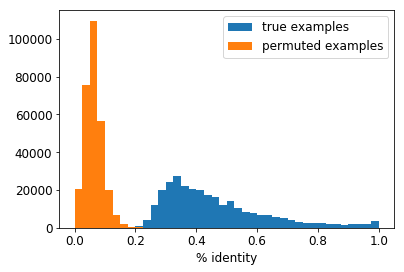

In [24]:
with plt.rc_context(rc={"font.size": 12}):
    plt.hist(sample_df['identity_calc'], range=(0, 1), bins=40, label="true examples")
    plt.hist(sample_df['identity_permute_calc'], range=(0, 1), bins=40, label="permuted examples")
    plt.xlabel("% identity")
    plt.legend()

## % identity vs. RMSD

### `pc_identity_vs_rmsd`

In [25]:
# data_txt
data_txt = """\
pc_identity,gdt_ts
78.91816903490144, 93.00102913565063
77.15940345976479, 90.35720067273232
76.88890358247401, 89.88261439756785
75.06610778675105, 84.05022394498152
74.99929709752887, 83.23618217035641
7.0114368968734535, 43.01694167821181
6.804490588402837, 46.13797800100842
9.649863306442038, 46.745232351084965
9.919171554317431, 48.237470146982126
6.39194848479903, 51.22671225643794
9.915755549993348, 51.154737839749124
11.136460723106405, 50.33918666786453
13.238336127910861, 49.31907244634007
12.488721783677176, 52.91564834783347
10.385416423574265, 55.15694439423713
12.482843078561311, 57.93606251678132
10.991161376391334, 58.6840880217945
13.1580203053144, 60.038414573351936
12.750483045255178, 60.85301244170422
15.1219050238181, 61.121605711930385
15.05620652205027, 59.35775585128811
16.547729340298197, 58.74541721570595
16.212404822810875, 55.760703298028574
16.145673575549715, 54.878818088687936
15.87191657785691, 57.18581263685944
15.525549627787088, 63.63133614463816
15.99656101470543, 66.48020430896247
15.926493205081217, 68.44774335767335
16.941840908944158, 69.39635981427512
21.086248573667255, 60.16480673334301
22.105647817542483, 57.65340801945369
19.0572214471229, 56.8428616911137
21.55781605431278, 62.538770854658736
21.009428197355902, 67.89903773287236
22.90626390075434, 68.37171740097223
22.700747547582175, 70.27157189888963
18.903898462344287, 72.03994995131035
26.15655229413894, 70.40320722830837
26.087120020202924, 71.82799879929513
28.527418178974685, 71.14670454154312
31.299704292870715, 76.29954845951997
28.585013600717943, 79.83058474316758
28.04186891318873, 80.71318493015742
31.564246023084593, 81.86239233834782
33.12051403956805, 83.82802477999407
32.98331777287755, 85.25289579294187
28.100417638464286, 88.58294391519576
27.96282416196867, 90.3470321017211
27.8932330041106, 91.9075105421389
42.88528156290124, 78.04989318678795
43.09326061686517, 74.0468922126897
47.289226114293626, 78.65532037176092
47.694380115522094, 79.87602554487398
47.41601548408983, 86.11793930654515
46.668784398686896, 87.6792121665732
46.731146338091676, 92.29248628526696
47.678650607239106, 93.30902561854528
52.559246924782634, 91.94643710304123
52.69898533422594, 88.35057617919706
60.08613440603624, 87.5956392235747
60.020753672112505, 85.56041562407037
62.86557029642452, 86.6425740171555
62.79383420561879, 90.03482519489211
62.792563134242386, 91.12032015034029
61.36840709894382, 92.07179651753898
63.53359774668536, 94.85083519812216
74.5806379629261, 93.54886089888032
75.18685956750933, 96.66894391814463
"""

In [26]:
buf = io.StringIO()
buf.write(data_txt)
buf.seek(0)
pc_identity_vs_rmsd = pd.read_csv(buf)
pc_identity_vs_rmsd = pc_identity_vs_rmsd / 100
pc_identity_vs_rmsd.head()

,pc_identity,gdt_ts
0,0.789182,0.930010
1,0.771594,0.903572
2,0.768889,0.898826
3,0.750661,0.840502
4,0.749993,0.832362


# Fit function

In [27]:
from scipy import optimize

In [28]:
def fn(x, m):
    x = np.clip(x, 0.000001, 1)
    x = np.log(x)
    x = m * x + 1
    x = np.clip(x, 0, 1)
    return x

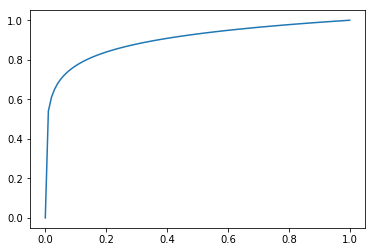

In [29]:
x = np.linspace(0, 1, 100)
plt.plot(x, fn(x, 0.1))

In [30]:
p, cov = optimize.curve_fit(
    fn,
    pc_identity_vs_rmsd['pc_identity'].values,
    pc_identity_vs_rmsd['gdt_ts'].values,
    (0.1))
p, cov

(array([0.20500374]), array([[2.50704438e-05]]))

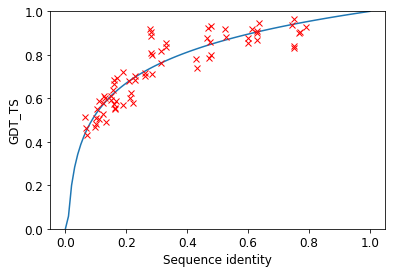

In [31]:
x = np.linspace(0, 1, 100)
with plt.rc_context(rc={"font.size": 12}):
    plt.plot(x, fn(x, *p))
    plt.plot(pc_identity_vs_rmsd['pc_identity'], pc_identity_vs_rmsd['gdt_ts'], 'rx')
    plt.ylim(0, 1)
    plt.xlabel("Sequence identity")
    plt.ylabel("GDT_TS")

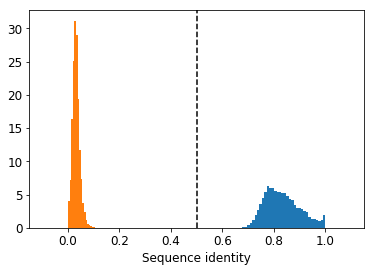

In [35]:
with plt.rc_context(rc={"font.size": 12}):
    ic = fn(sample_df['identity_calc'], 0.2)
    icp = (sample_df['identity_permute_calc']) / 2
    plt.hist(ic, bins=40, density=True, label="True examples")
    plt.hist(icp, bins=40, density=True, label="Permuted examples")
    ylim = plt.ylim()
    plt.vlines(0.5, *ylim, 'k', linestyle='--')
    plt.ylim(ylim)
    plt.xlim(-0.15, 1.15)
    plt.xlabel("Sequence identity")

In [36]:
icp.mean()

0.03156373299425843

In [37]:
icp.median()

0.030303030303030304